# Workshop Artificial Intelligence
# MNIST with fully connected networks and grid/random search

The following code imports the NumPy library, a fundamental package for scientific computing with Python. It provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays. Moreover, the code imports parts of the matplotlib library, which is used for creating static, animated, and interactive visualizations in Python. In addition, the code imports the os module, which provides a way of interacting with the operating system. Also, the TensorFlow library is imported. It is an open-source machine learning framework. TensorFlow is widely used for building and training deep learning models. Furthermore, the code imports the tabulate library, which is used for creating nicely formatted tables from various data sources, such as Python lists and dictionaries. Finally, the code imports the layers module from the Keras API, which is integrated into TensorFlow. Keras is a high-level neural networks API, and the layers module contains building blocks for constructing neural network architectures.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers
import math

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data.

The following code is preparing image data for a machine learning model by dividing it into training, validation, and test sets, and then normalizing the pixel values for better model convergence.

In [3]:
# load input and output data for training and test
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# divide test data into test data and validation data
x_valid = x_test[8000:]
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# analyze input data
print("Min value input data before conversion:", np.amin(np.concatenate((x_train, x_valid, x_test))))
print("Max value input data before conversion:", np.amax(np.concatenate((x_train, x_valid, x_test))))
print()

# convert input data
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0

# analyze input data
print("Min value input data after conversion:", np.amin(np.concatenate((x_train, x_valid, x_test))))
print("Max value input data after conversion:", np.amax(np.concatenate((x_train, x_valid, x_test))))
print()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Min value input data before conversion: 0
Max value input data before conversion: 255

Min value input data after conversion: 0.0
Max value input data after conversion: 1.0

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [4]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)
input_shape = x_train.shape[1]

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a zero is encoded as `[1,0,0,0,0,0,0,0,0,0]` a one as `[0,1,0,0,0,0,0,0,0,0]` etc.
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [5]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

### 🔧 To be done
Modify the lines marked with "...".


The following code constructs a simple neural network with a specified architecture, suitable for a classification task. The ReLU activation is used for hidden layers, and softmax is applied to the output layer for probability distribution over classes.

In [7]:

# define model here
model = tf.keras.models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    layers.Dense(64, activation='relu'),      # Hidden layer hinzugefügt
    layers.Dense(10, activation='softmax')    # 10 Klassen, softmax für Klassifikation
])


print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

None


 The following code encompasses the key steps in training a neural network for a classification task, including model compilation, callback definition, and the training process with specified metrics and callbacks.

In [8]:
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.weights.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and with regularization applied,
# while the validation metrics are calculated at the end of each epoch.
# This callback calculates the training metrics the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    batch_size=64,
    epochs=10,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
    )

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8583 - loss: 0.4886 - val_accuracy: 0.9630 - val_loss: 0.1102 - train_loss: 0.1368 - train_acc: 0.9587
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9653 - loss: 0.1176 - val_accuracy: 0.9775 - val_loss: 0.0751 - train_loss: 0.0859 - train_acc: 0.9736
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9766 - loss: 0.0774 - val_accuracy: 0.9765 - val_loss: 0.0701 - train_loss: 0.0551 - train_acc: 0.9836
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9820 - loss: 0.0587 - val_accuracy: 0.9860 - val_loss: 0.0510 - train_loss: 0.0387 - train_acc: 0.9886
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9860 - loss: 0.0429 - val_accuracy: 0.9810 - val_loss: 0.0660 - train_loss: 0.0359 - train_acc: 0.9888
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9893 - loss: 0.0361 - val_accuracy: 0.9835 - val_loss: 0.0619 - train_loss: 0.0231 - tra

### 🔧 To be done
Modify the lines marked with "...".


The following code visualizes the training and validation accuracy recorded during the model training process. The x-axis represents epochs, and the y-axis represents accuracy. The plot includes two lines: one for training accuracy and one for validation accuracy.

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy')]

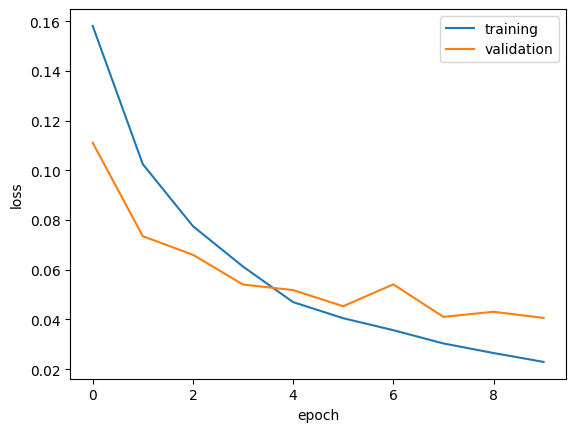

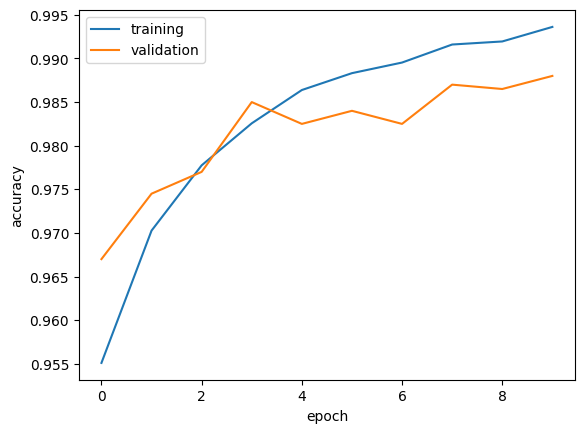

In [ ]:
# load best model
model.load_weights(f"best_model_{model.name}.weights.h5")

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
fig, ax = plt.subplots(1)
ax.plot(history['epoch'], history['train_acc'], label='Training Accuracy')
ax.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Trainings- und Validierungsgenauigkeit')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

The following code obtains loss and accuracy metrics, calculates the test error rate, and then prints a formatted table summarizing the model's performance.

In [ ]:
# evaluate performance
print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    ["Train", *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Validation", *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Test", *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])*100 ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0229232 |   0.993617 |              0.638336 |
| Validation | 0.0406281 |   0.988    |              1.2      |
| Test       | 0.0691826 |   0.97825  |              2.175    |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [ ]:
def plot_image(X, ax=None):
    """Plot an image X.

    Args:
        X (2D array): image, grayscale or RGB
        ax (None, optional): Description
    """
    if ax is None:
        ax = plt.gca()

    if (X.ndim == 2) or (X.shape[-1] == 1):
        ax.imshow(X.astype('uint8'), origin='upper', cmap=plt.cm.Greys)
    else:
        ax.imshow(X.astype('uint8'), origin='upper')

    ax.set(xticks=[], yticks=[])

def plot_prediction(Yp, X, y, classes=None, top_n=False):
    """Plot an image along with all or the top_n predictions.

    Args:
        Yp (1D array): predicted probabilities for each class
        X (2D array): image
        y (integer): true class label
        classes (1D array, optional): class names
        top_n (int, optional): number of top predictions to show
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)
    plot_image(X, ax1)

    if top_n:
        n = top_n
        s = np.argsort(Yp)[-top_n:]
    else:
        n = len(Yp)
        s = np.arange(n)[::-1]

    patches = ax2.barh(np.arange(n), Yp[s], align='center')
    ax2.set(xlim=(0, 1), xlabel='Probability', yticks=[])

    for iy, patch in zip(s, patches):
        if iy == y:
            patch.set_facecolor('C1')  # color correct patch

    if classes is None:
        classes = np.arange(0, np.size(Yp))

    for i in range(n):
        ax2.text(0.05, i, classes[s][i], ha='left', va='center')

    plt.show()

def plot_confusion(yp, y, classes=None, fname=None):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    if classes is None:
        n = max(max(yp), max(y)) + 1
        classes = np.arange(n)
    else:
        n = len(classes)

    bins = np.linspace(-0.5, n - 0.5, n + 1)
    C = np.histogram2d(y, yp, bins=bins)[0]
    C = C / np.sum(C, axis=0) * 100

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(C, interpolation='nearest', vmin=0, vmax=100, cmap=plt.cm.YlGnBu)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label('Frequency %')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(n), classes, rotation='vertical')
    plt.yticks(range(n), classes)
    for x in range(n):
        for y in range(n):
            if np.isnan(C[x, y]):
                continue
            color = 'white' if x == y else 'black'
            plt.annotate('%.1f' % (C[x, y]), xy=(y, x), color=color, ha='center', va='center')

    plt.show()

The following code plots the model predictions (output) for the first 10 test samples alongside the corresponding original images (x_test[i]) and their true labels (labels[i]).

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


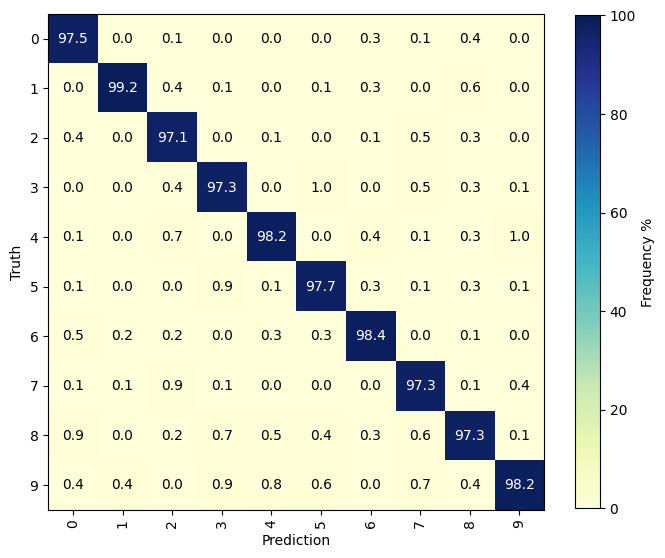

In [ ]:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

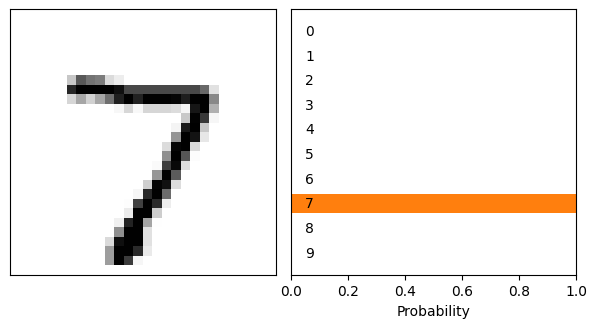

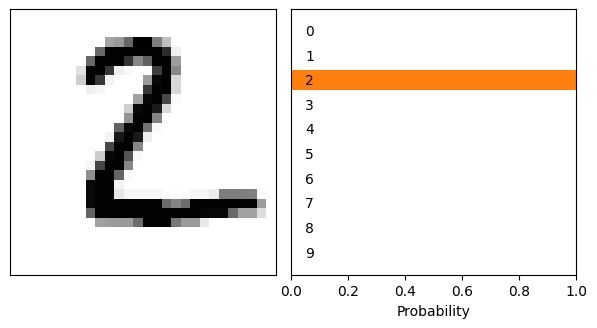

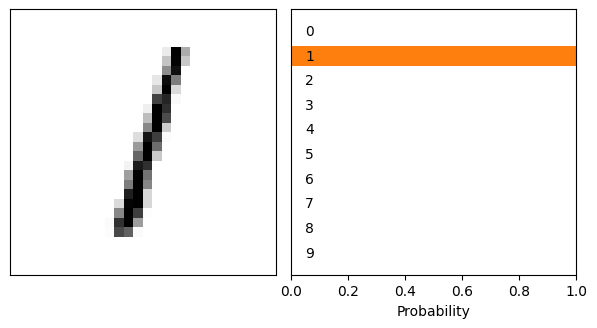

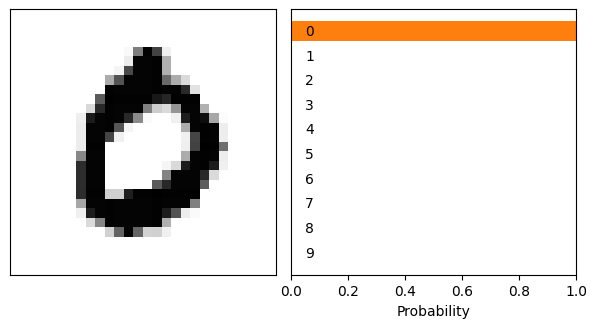

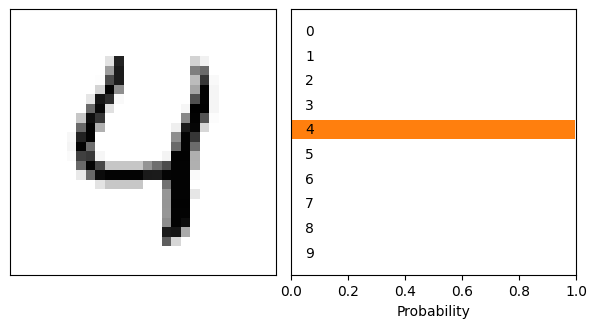

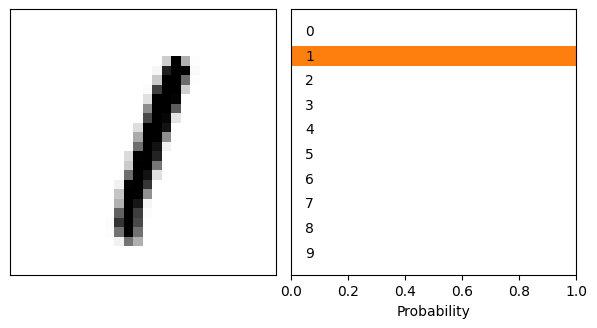

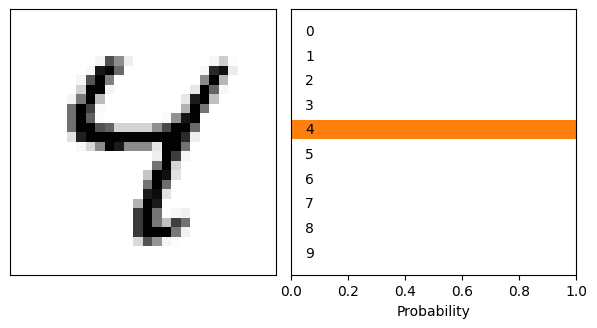

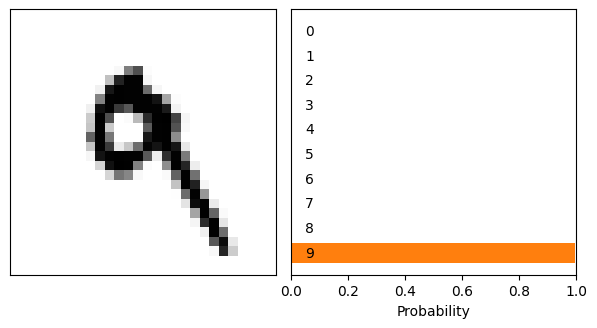

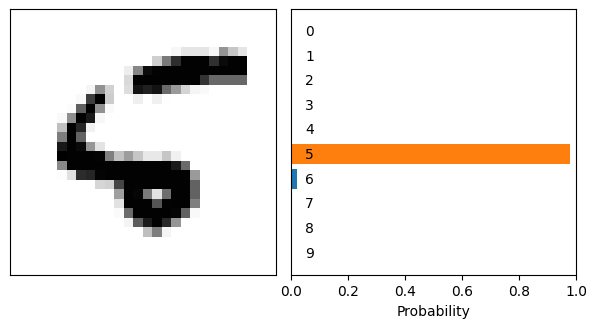

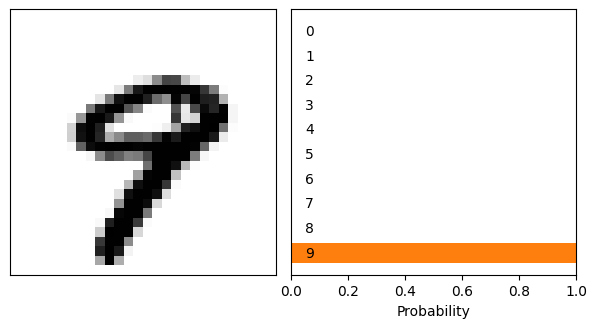

In [ ]:
# plot a few examples, loop over test dataset:
for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])


The following code identifies misclassified examples by comparing the predicted labels (predictions) with the true labels (labels). It then plots either the first 10 individual misclassified examples as well as a joint plot of 32 misclassified examples. The reshaping of image data is performed to ensure compatibility with the plotting function. The joint plot aims to provide a compact overview of multiple misclassified examples.

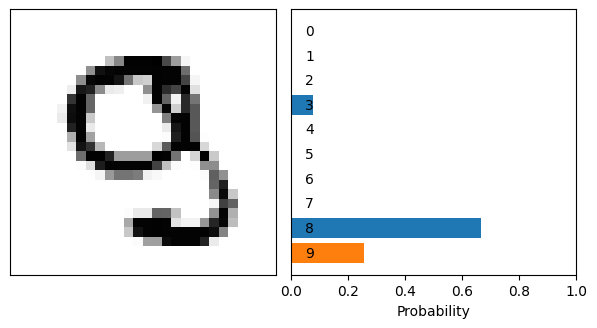

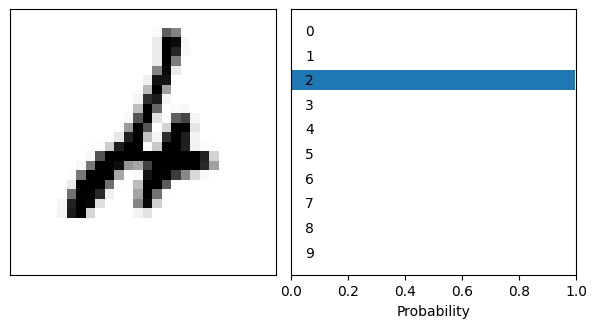

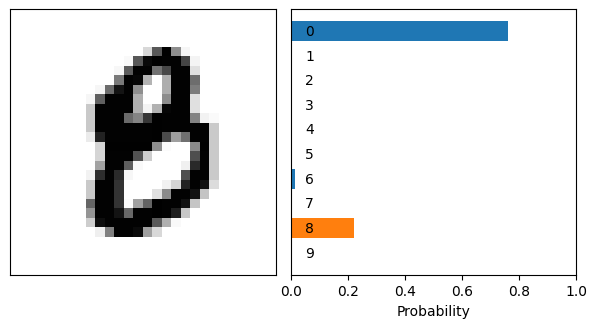

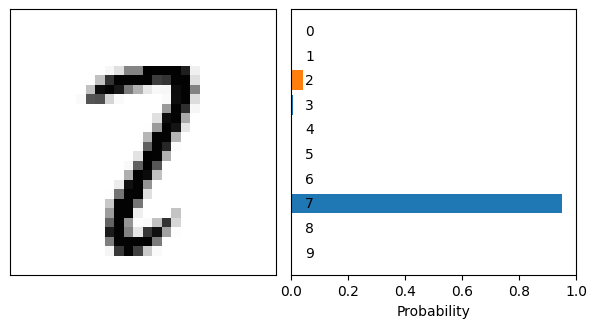

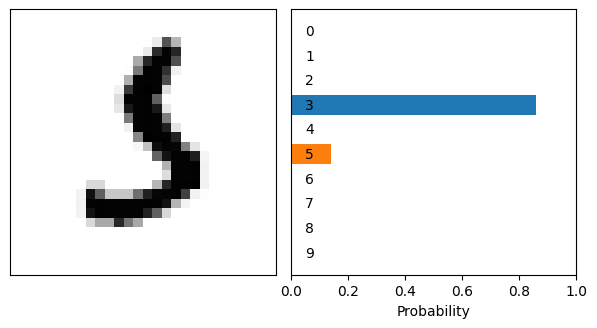

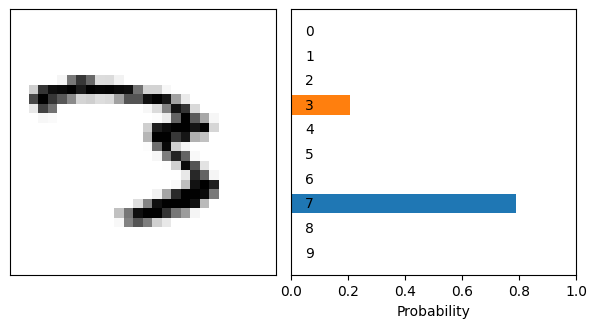

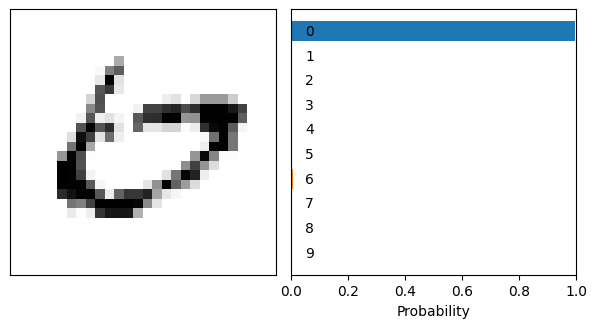

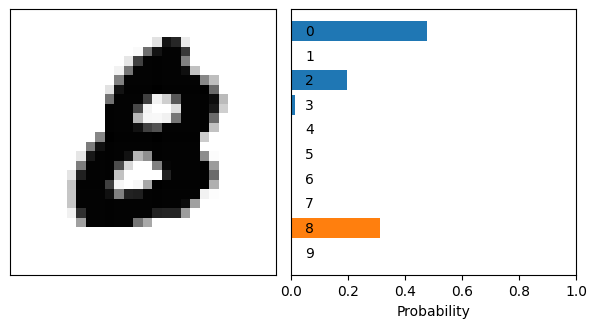

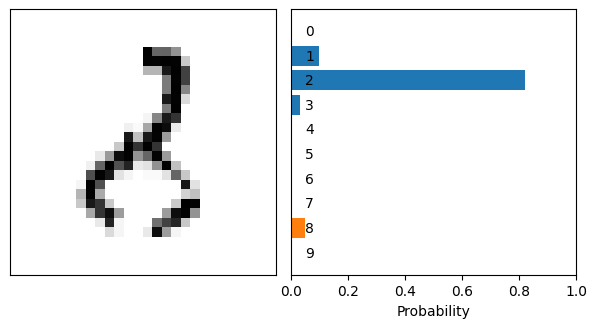

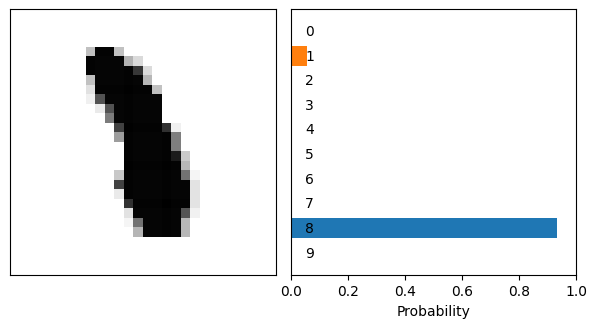

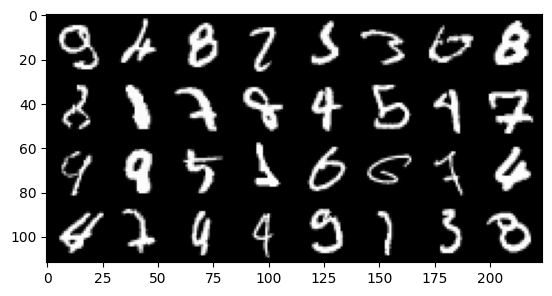

In [ ]:
# plot a few examples that were misclassified
indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# plot 32 misclassified examples in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap = "gray")

**Grid search**

Let's search the two hyperparameters dropout and number of nodes



### 🔧 To be done
Modify the lines marked with "...".


The following code will perform a grid search, training and evaluating models for different combinations of dropout and number of neurons.

In [ ]:
# define values for hyperparameters
dropout_values = [0.2, 0.35, 0.5]
n_neurons_values = [128, 256, 384]

# initialize results grid
results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))

# loop over hyperparameters
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    # build model
    model = tf.keras.models.Sequential([
        layers.Dense(n_neurons, input_shape = (input_shape,), activation = 'relu'),
        ...
        layers.Dense(10),
        layers.Activation('softmax') # softmax actication to transform output into probabiliites
        ])

    # compile model
    model.compile(
        loss = 'categorical_crossentropy', # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
        optimizer = ...,
        metrics = ['accuracy'] # we use accuracy to quanitfy to network performance.
        )

    # train model
    results = model.fit(
        x_train, y_train_onehot,
        validation_data = (x_valid, y_valid_onehot),
        batch_size = 32,
        epochs = 10,
        verbose = 0
        )

    # evaluate on test set
    t = model.evaluate(x_test, y_test_onehot, verbose = 0, batch_size = 128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


[Text(0, 0, '32'),
 Text(1, 0, '64'),
 Text(2, 0, '128'),
 Text(3, 0, '256'),
 Text(4, 0, '512')]

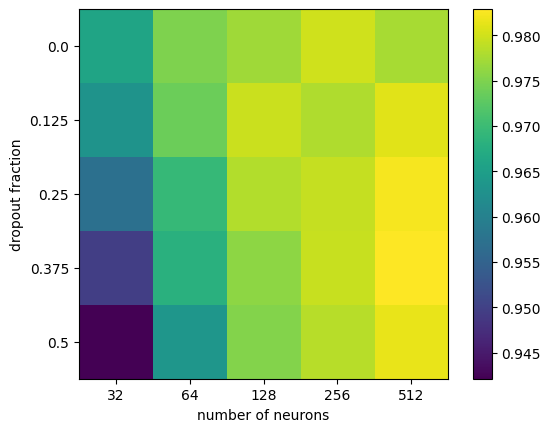

In [ ]:
# now plot the results
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(results_gridsearch[:,:,1])
fig.colorbar(pos, ax=ax)
ax.set_xlabel("number of neurons")
ax.set_ylabel("dropout fraction")
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(dropout_values)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(n_neurons_values)


### 🔧 To be done
Modify the lines marked with "...".


Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time.

In [ ]:
# define number of trials
N = 20

search = {
    'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
    'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
    'learn_rate': np.random.choice([-5, -4, -3, -2, -1], N),
    'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
    'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
    'val_acc': np.zeros(N)
    }

best_val_loss_mean_std = []

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(..., input_shape = (input_shape,), ...),
      ...
      tf.keras.layers.Dense(10, activation = 'softmax')
      ])
  model.compile(
      loss='categorical_crossentropy',
      optimizer = ...,
      metrics=['accuracy']
      )
  results = model.fit(
      x_train, y_train_onehot,
      validation_data = (x_valid, y_valid_onehot),
      batch_size = ...,
      epochs = 10,
      verbose = 0
      )

  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose = 0, batch_size = 128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")

  # store validation loss for each trial
  val_loss = results.history['val_loss'][-1]
  best_val_loss_mean_std.append(val_loss)

iteration 0:
	batch_size: 64
	num_neurons: 8
	learn_rate: -1
	activation: elu
	dropout: 0.5
	val_acc: 0.31937500834465027
	-> accuracy 0.319, error rate = 68.1%
iteration 1:
	batch_size: 256
	num_neurons: 512
	learn_rate: -3
	activation: relu
	dropout: 0.1
	val_acc: 0.9803749918937683
	-> accuracy 0.980, error rate = 2.0%
iteration 2:
	batch_size: 16
	num_neurons: 256
	learn_rate: -1
	activation: sigmoid
	dropout: 0.2
	val_acc: 0.8792499899864197
	-> accuracy 0.879, error rate = 12.1%
iteration 3:
	batch_size: 32
	num_neurons: 512
	learn_rate: -5
	activation: elu
	dropout: 0.6
	val_acc: 0.906499981880188
	-> accuracy 0.906, error rate = 9.4%


Text(0, 0.5, 'validation accuracy')

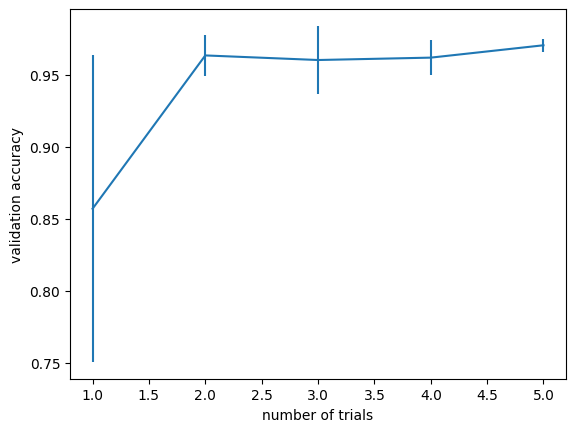

In [ ]:
# plot best validation loss (mean + std) vs. number of trials
mean_val_loss = np.mean(best_val_loss_mean_std)
std_val_loss = np.std(best_val_loss_mean_std)
plt.errorbar(range(1, N + 1), best_val_loss_mean_std, yerr = std_val_loss, fmt = '-o', label = 'Validation Loss')
plt.axhline(y = mean_val_loss, color = 'r', linestyle = '--', label = 'Mean Validation Loss')
plt.xlabel('Number of Trials')
plt.ylabel('Validation Loss')
plt.title('Best Validation Loss vs. Number of Trials')
plt.legend()
plt.show()